## Three centuries of English grain production in Oxfordshire, England on the Adderbury Manor.
### Linear modelling and state space modelling using Pystan.

Ara Winter<br>
2017-06-29

CC-BY 4.0

This documents uses a model that compares the means and standard deviations of two groups. This is carried out in the pystan framework. 

In [1]:
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
from IPython.display import Image
import numpy as np
%matplotlib inline

### Example: Three centuries of English grain production
To demostrate this model we will be using the Three centuries of English crop yields, 1211-1491. The full dataset is describe here: http://www.cropyields.ac.uk/login.php . 

We are using a small subset of the total data. The data set contains: wheat gross yield per seed ratio, county, manor, estate, and year. 


#### Reference
Bruce M. S. Campbell (2007), Three centuries of English crops yields, 1211‑1491 [WWW document]. URL http://www.cropyields.ac.uk [accessed on 29/June/2017]

### Where are we?
We are looking at data from a single county with multiple manors.

<tr>
<td> Oxfordshire<img src="200px-Oxfordshire_UK_locator_map_2010.svg.png" alt="Oxfordshire" style="width: 250px;"/> </td>
</tr>

maps by Unknown (wikimedia), distributed Creative Commons Attribution-Share Alike 3.0 Unported

### Data
First we need to load the .csv with the data in it. Here we are going to use pandas (acts like a R data frame) and from there pull out the data we need.

In [4]:
# Import data
grain_data = pd.read_csv('./three_centuries_of_grain/oxfordshire_wheat_barley_oats_grain_1349_1458.csv', sep=",")
# Here I am telling pd.read_csv that in the folder where my notebook is I have another folder called:
# three_centuries_of_grain. And in that folder I have a tab (\t) seperated comma seperated file. 
# We then ask pandas to read it in and stick it in a data frame called grain_data

In [5]:
grain_data.head(4)

,county name,manor name,estate name,start year,end year,wheat gross yield per seed ratio,barley gross yield per seed ratio,dredge gross yield per seed ratio,oats gross yield per seed ratio,source
0,Oxfordshire,Adderbury,Bishop of Winchester,1210,1211,3.87,7.21,NaN,4.48,Titow (to 1349); Farmer (from 1350)
1,Oxfordshire,Adderbury,Bishop of Winchester,1217,1218,NaN,NaN,NaN,NaN,Titow (to 1349); Farmer (from 1350)
2,Oxfordshire,Adderbury,Bishop of Winchester,1218,1219,NaN,NaN,NaN,NaN,Titow (to 1349); Farmer (from 1350)
3,Oxfordshire,Adderbury,Bishop of Winchester,1219,1220,NaN,NaN,NaN,NaN,Titow (to 1349); Farmer (from 1350)


In [6]:
grain_data.describe()

,start year,end year,wheat gross yield per seed ratio,barley gross yield per seed ratio,dredge gross yield per seed ratio,oats gross yield per seed ratio
count,629.000000,629.000000,287.000000,183.000000,136.000000,291.000000
mean,1346.600954,1347.600954,3.639582,4.235137,3.020882,2.721684
std,56.308732,56.308732,1.398743,1.339135,1.457502,0.966774
min,1210.000000,1211.000000,1.380000,0.840000,0.000000,0.600000
25%,1304.000000,1305.000000,2.690000,3.415000,2.357500,2.035000
50%,1347.000000,1348.000000,3.350000,4.070000,3.045000,2.560000
75%,1386.000000,1387.000000,4.245000,5.035000,3.915000,3.300000
max,1458.000000,1459.000000,8.820000,7.910000,6.760000,6.060000


In [7]:
# Check for missing data
grain_data.isnull().sum()

county name                            0
manor name                             0
estate name                            0
start year                             0
end year                               0
wheat gross yield per seed ratio     342
barley gross yield per seed ratio    446
dredge gross yield per seed ratio    493
oats gross yield per seed ratio      338
source                                 0
dtype: int64

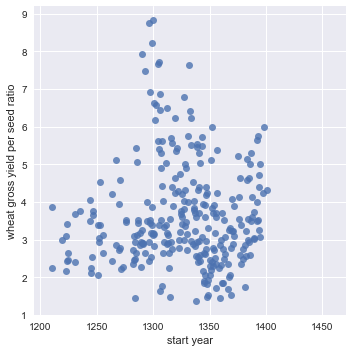

In [11]:
# Exploratory plot of the whole data set by year.
sns.lmplot("start year", "wheat gross yield per seed ratio", data=grain_data, fit_reg=False)

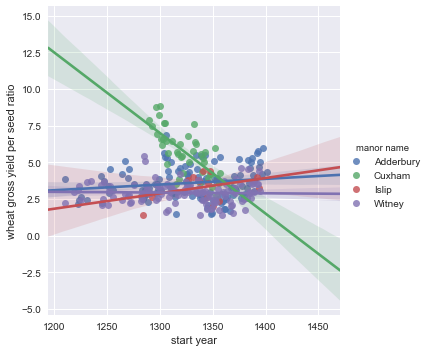

In [12]:
# We actually have a hierarchy of manors. 
sns.lmplot("start year", "wheat gross yield per seed ratio", data=grain_data, hue='manor name', fit_reg=True)

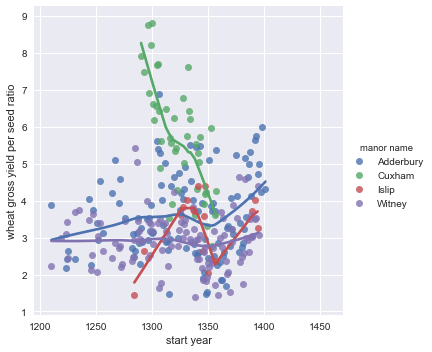

In [13]:
# Exploratory plot of the whole data set with lowess regression lines. 
sns.lmplot("start year", "wheat gross yield per seed ratio", data=grain_data, hue='manor name', lowess=True)

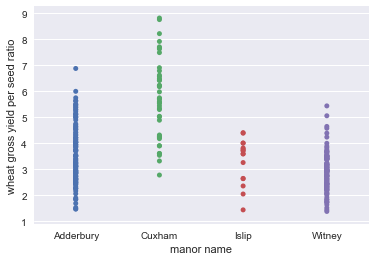

In [21]:
# Differences in crop yield by county.
sns.stripplot(x="manor name", y="wheat gross yield per seed ratio", data=grain_data);

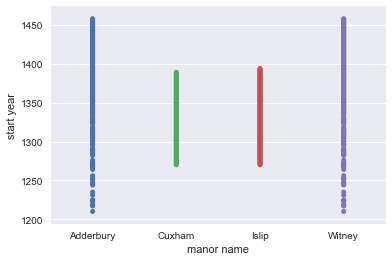

In [22]:
# Differences in data points by years.
sns.stripplot(x="manor name", y="start year", data=grain_data);

In [154]:
# Here we pick just the data from Adderbury manor.
adderbury = grain_data.loc[grain_data['manor name'] == "Adderbury"]

In [157]:
# Subset to just include the wheat data.
adderbury_wheat = adderbury[adderbury.columns[0:6]]

In [158]:
# Remove the whitespace in the columns so it's easier to call the column titles.
adderbury_wheat.columns = [c.replace(' ', '_') for c in adderbury_wheat.columns]

In [159]:
adderbury_wheat.head(4)

,county_name,manor_name,estate_name,start_year,end_year,wheat_gross_yield_per_seed_ratio
0,Oxfordshire,Adderbury,Bishop of Winchester,1210,1211,3.87
1,Oxfordshire,Adderbury,Bishop of Winchester,1217,1218,NaN
2,Oxfordshire,Adderbury,Bishop of Winchester,1218,1219,NaN
3,Oxfordshire,Adderbury,Bishop of Winchester,1219,1220,NaN


In [66]:
# This allows us to only have complete cases. 
adderbury_complete_wheat = adderbury_wheat.dropna(axis=0, how='any')

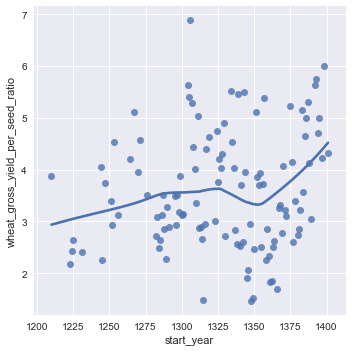

In [68]:
sns.lmplot("start_year", "wheat_gross_yield_per_seed_ratio", data=adderbury_complete_wheat, lowess=True)

In [69]:
# Here we want to see if the year predicts total wheat yield in Berkshire county. 
y1 = adderbury_complete_wheat.wheat_gross_yield_per_seed_ratio.tolist()
year = adderbury_complete_wheat.start_year.tolist()
n1 = len(y1)

In [70]:
model_data = {'y1': y1, 'time': year,'N':n1}

In [71]:
model_string = """
data {
  int<lower=0> N;
  vector[N] y1; //response variable
  vector[N] time; //predictor
}
parameters {
  vector[2] beta;
  real<lower=0> sigma;
}
model {
  y1 ~ normal(beta[1] + beta[2] * time, sigma);
}
"""

In [72]:
# Compiling and producing posterior samples from the model.
fit_linear_one_predict = pystan.stan(model_code=model_string, data=model_data,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a97b2298c8a162e9f69f50714c73c28a NOW.


In [73]:
fit_linear_one_predict

Inference for Stan model: anon_model_a97b2298c8a162e9f69f50714c73c28a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  -1.65    0.13   3.22  -8.24   -3.8   -1.6   0.59   4.57    627    1.0
beta[1] 4.0e-3  9.7e-5 2.4e-3-7.2e-4 2.3e-3 3.9e-3 5.6e-3 8.9e-3    626    1.0
sigma     1.14  3.0e-3   0.08   0.99   1.08   1.13   1.19   1.29    640   1.01
lp__    -71.77    0.06   1.29 -75.06 -72.37 -71.39 -70.83 -70.33    501   1.01

Samples were drawn using NUTS at Thu Jul 13 09:30:14 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

beta[0] is the intercept

beta[1] is the slope

sigma is the noise term that is normally distributed

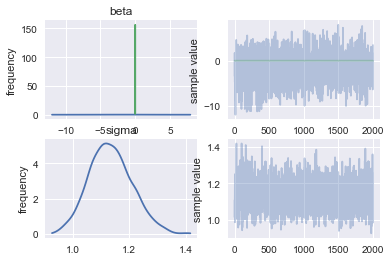

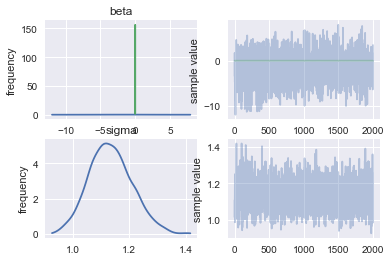

In [74]:
# Plotting the posterior distribution
fit_linear_one_predict.plot()

In [75]:
# return a dictionary of arrays
samples = fit_linear_one_predict.extract(permuted=True)
for k, v in samples.items():
    print(k, v.shape)

beta (2000, 2)
sigma (2000,)
lp__ (2000,)


In [76]:
# return a 3d array (samples, chains, coeffs)
samples = fit_linear_one_predict.extract(permuted=False) 
print(samples.shape)

(500, 4, 4)


In [77]:
dftrc_robust_stan = pd.DataFrame(samples.reshape(2000,4),
                               columns=['beta0','beta1','sigma', 'lp__'])

In [78]:
dftrc_robust_stan.head(4)

,beta0,beta1,sigma,lp__
0,-3.610834,0.005380,1.200023,-71.128075
1,-0.793858,0.003259,1.097089,-70.471183
2,-1.755600,0.003985,1.066093,-70.649140
3,-1.587756,0.004019,1.186393,-71.566543


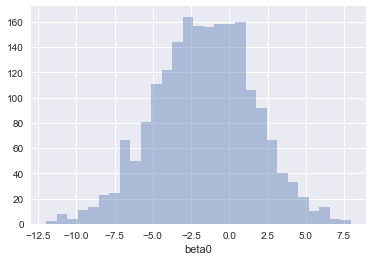

In [79]:
sns.distplot(dftrc_robust_stan.beta0, kde=False, rug=False);

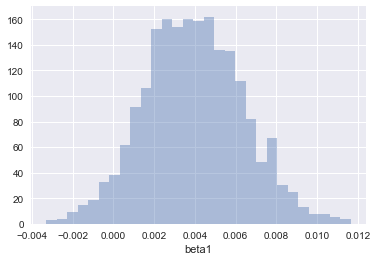

In [80]:
sns.distplot(dftrc_robust_stan.beta1, kde=False, rug=False);

### PREDICTION
The prediction code comes from https://climateecology.wordpress.com/2014/01/27/pystan-a-basic-tutorial-of-bayesian-data-analysis-in-python/ which is no longer active. 

In [85]:
# make a dataframe of parameter estimates for all chains
params = dftrc_robust_stan[['beta0', 'beta1',]].copy()
 
# next, make a prediction function. Making a function makes every step following this 10 times easier
def stanPred(p):
 fitted = p[0] + p[1] * predX
 return pd.Series({'fitted': fitted})
 
# make a prediction vector (the values of X for which you want to predict)
predX = np.arange(1200, 1500)
 
# get the median parameter estimates
medParam = params.median()
# predict
yhat = stanPred(medParam)
 
# get the predicted values for each chain. This is super convenient in pandas because
# it is possible to have a single column where each element is a list
chainPreds = params.apply(stanPred, axis = 1)

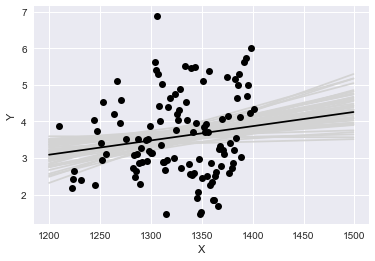

In [86]:
## PLOTTING
 
# create a random index for chain sampling
idx = np.random.choice(1999, 50)
# plot each chain. chainPreds.iloc[i, 0] gets predicted values from the ith set of parameter estimates
for i in range(len(idx)):
 plt.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
 
# original data from the adderbury_complete_wheat dataframe
plt.plot(adderbury_complete_wheat.start_year, adderbury_complete_wheat.wheat_gross_yield_per_seed_ratio, 'ko')
# fitted values
plt.plot(predX, yhat['fitted'], 'k')
 
# supplementals
plt.xlabel('X')
plt.ylabel('Y')
 
plt.show()

### Linear model with informed priors.
This is likely a better model.

In [104]:
model_string2 = """
data {
  int<lower=0> N;
  vector[N] y1; //response
  vector[N] time; //predictor
}
parameters {
  vector[2] beta;
  real<lower=0> sigma;
}
model {
  sigma ~ cauchy(0, 2);
  y1 ~ normal(beta[1] + beta[2] * time, sigma); //informed prior
}
"""

In [105]:
# Compiling and producing posterior samples from the model.
fit_linear_informed = pystan.stan(model_code=model_string2, data=model_data,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_91a411ab6022a0d64632b2edc95b783e NOW.


In [106]:
fit_linear_informed

Inference for Stan model: anon_model_91a411ab6022a0d64632b2edc95b783e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  -1.65    0.12   3.01  -8.09  -3.67  -1.64   0.22   4.23    674    1.0
beta[1] 4.0e-3  8.7e-5 2.3e-3-4.7e-4 2.5e-3 3.9e-3 5.4e-3 8.7e-3    676    1.0
sigma     1.14  2.8e-3   0.08    1.0   1.09   1.13   1.19   1.29    725   1.01
lp__    -71.98    0.05   1.25 -75.14 -72.56 -71.61 -71.06 -70.57    563   1.01

Samples were drawn using NUTS at Thu Jul 13 09:51:22 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

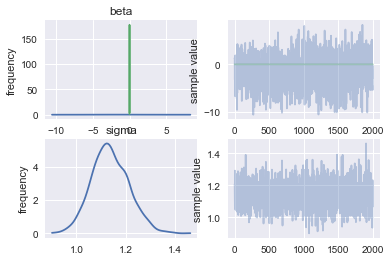

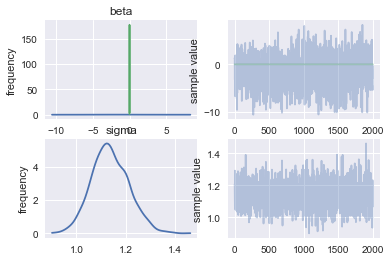

In [107]:
fit_linear_informed.plot()

In [108]:
# return a dictionary of arrays
samples = fit_linear_informed.extract(permuted=True)
for k, v in samples.items():
    print(k, v.shape)

beta (2000, 2)
sigma (2000,)
lp__ (2000,)


In [109]:
# return a 3d array (samples, chains, coeffs)
samples = fit_linear_informed.extract(permuted=False) 
print(samples.shape)

(500, 4, 4)


In [111]:
dftrc_robust_stan = pd.DataFrame(samples.reshape(2000,4),
                               columns=['beta0','beta1','sigma','lp__'])

In [112]:
# make a dataframe of parameter estimates for all chains
params = dftrc_robust_stan[['beta0', 'beta1',]].copy()
 
# next, make a prediction function. Making a function makes every step following this 10 times easier
def stanPred(p):
 fitted = p[0] + p[1] * predX
 return pd.Series({'fitted': fitted})
 
# make a prediction vector (the values of X for which you want to predict)
predX = np.arange(1200, 1500)
 
# get the median parameter estimates
medParam = params.median()
# predict
yhat = stanPred(medParam)
 
# get the predicted values for each chain. This is super convenient in pandas because
# it is possible to have a single column where each element is a list
chainPreds = params.apply(stanPred, axis = 1)

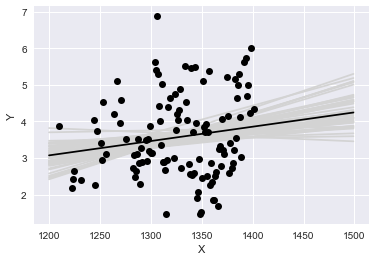

In [113]:
## PLOTTING
 
# create a random index for chain sampling
idx = np.random.choice(1999, 50)
# plot each chain. chainPreds.iloc[i, 0] gets predicted values from the ith set of parameter estimates
for i in range(len(idx)):
 plt.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
 
# original data
plt.plot(adderbury_complete_wheat.start_year, adderbury_complete_wheat.wheat_gross_yield_per_seed_ratio, 'ko')
# fitted values
plt.plot(predX, yhat['fitted'], 'k')
 
# supplementals
plt.xlabel('X')
plt.ylabel('Y')
 
plt.show()

### State space - Local level model
Since we have time series data we can look in a series of models called state space models. The level here is being allowed to vary across time. You can think of the level as the intercept in a linear regression model.


In [129]:
model_state_space_data = {'y': y1,'n':n1}

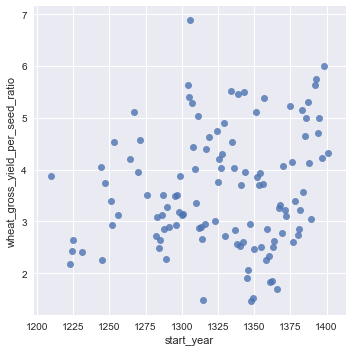

In [130]:
# Just a reminder of what the real data looks like. 
sns.lmplot("start_year", "wheat_gross_yield_per_seed_ratio", data=adderbury_complete_wheat, fit_reg=False)

In [153]:
# From https://github.com/sinhrks/stan-statespace accessed on 2017/07/13
# Local level model
model_state_space = """
data {
  int<lower=1> n;
  vector[n] y;
}
parameters {
  vector[n] mu;
  real<lower=0> sigma_level; //
  real<lower=0> sigma_irreg; //deviations of the observed time series from its mean.
}
transformed parameters {
  vector[n] yhat;
  yhat = mu;
}
model {
  for(t in 2:n)
    mu[t] ~ normal(mu[t-1], sigma_level);

  y ~ normal(yhat, sigma_irreg);
}
"""

In [122]:
# Compiling and producing posterior samples from the model.
fit_local_level = pystan.stan(model_code=model_state_space, data=model_state_space_data,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7aa88cff6aa2fd4bd658f5e00212cfc4 NOW.


In [123]:
fit_local_level

Inference for Stan model: anon_model_7aa88cff6aa2fd4bd658f5e00212cfc4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]         3.05    0.01   0.49    2.1   2.72   3.06   3.37   4.05   2000    1.0
mu[1]         2.88 10.0e-3   0.45   1.99   2.58   2.89   3.19   3.69   2000    1.0
mu[2]         2.85    0.01   0.42   1.97   2.57   2.85   3.15    3.6    935    1.0
mu[3]         2.88  9.0e-3    0.4   2.05   2.62   2.88   3.15   3.63   2000    1.0
mu[4]         2.95  8.8e-3    0.4   2.16   2.69   2.96   3.21   3.74   2000    1.0
mu[5]         3.13  9.0e-3    0.4   2.33   2.87   3.14    3.4    3.9   2000    1.0
mu[6]         3.14  8.9e-3    0.4   2.31   2.87   3.16    3.4    3.9   2000    1.0
mu[7]         3.31  8.8e-3   0.39   2.55   3.05   3.32   3.57   4.07   2000    1.0
mu[8]         3.39  8.7e-3   0.39    2.6   3.13   3.39   3.66   4.

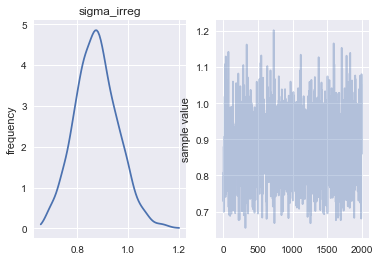

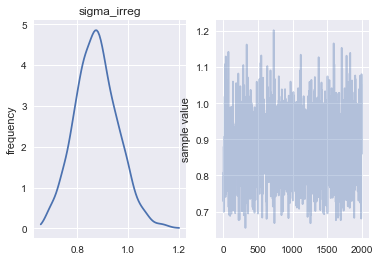

In [127]:
fit_local_level.plot(['sigma_irreg'])

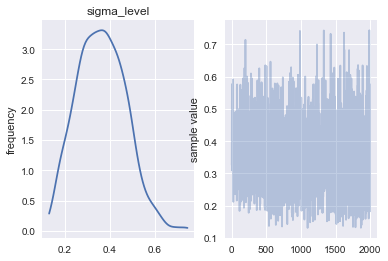

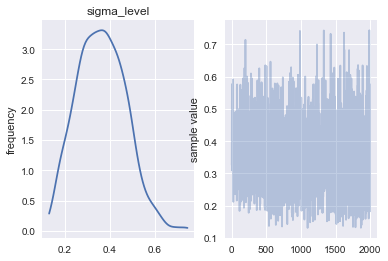

In [128]:
fit_local_level.plot(['sigma_level'])

In [166]:
yhat = fit_local_level.extract(permuted=True)['yhat']
yhat_mean = np.mean(yhat, axis=0)

In [165]:
mu = fit_local_level.extract(permuted=True)['mu']
mu_mean = np.mean(mu, axis=0)

In [202]:
# Gets the standard deviation of yhat
yhat_std = np.std(yhat, axis=0)

In [172]:
adderbury_complete_wheat['mean_yhat'] = yhat_mean

In [173]:
adderbury_complete_wheat['std_yhat'] = yhat_std

In [178]:
adderbury_complete_wheat.head(4)

,county_name,manor_name,estate_name,start_year,end_year,wheat_gross_yield_per_seed_ratio,mean_yhat,std_yhat
0,Oxfordshire,Adderbury,Bishop of Winchester,1210,1211,3.87,3.048664,0.487777
4,Oxfordshire,Adderbury,Bishop of Winchester,1223,1224,2.17,2.878039,0.446210
5,Oxfordshire,Adderbury,Bishop of Winchester,1224,1225,2.43,2.845072,0.421671
6,Oxfordshire,Adderbury,Bishop of Winchester,1225,1226,2.64,2.877870,0.403758


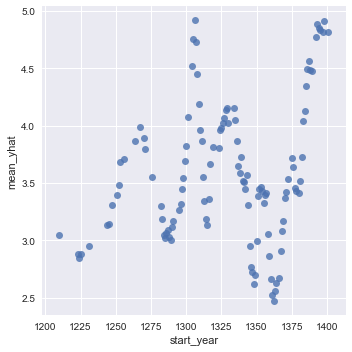

In [200]:
# Local level model of the mean yhat value. This can be taken as the mean modelled wheat gross yield per seed ratio.
sns.lmplot("start_year", "mean_yhat", data=adderbury_complete_wheat, fit_reg=False)

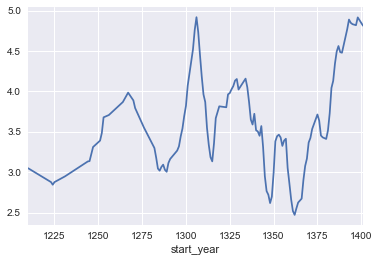

In [201]:
# Or as a time series plot
sns.tsplot(data=adderbury_complete_wheat.mean_yhat, time = adderbury_complete_wheat.start_year)

In [188]:
y_uncertainity = adderbury_complete_wheat['std_yhat'].tolist()

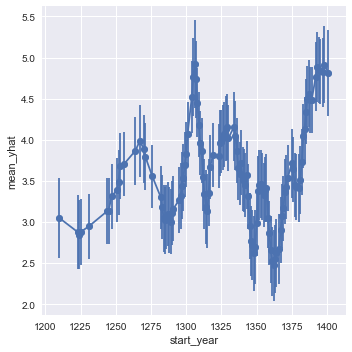

In [190]:
g = sns.lmplot("start_year", "mean_yhat", data=adderbury_complete_wheat, fit_reg=False)
g.map(plt.errorbar, "start_year", "mean_yhat", yerr=y_uncertainity , fmt='-o');

<Container object of 3 artists>

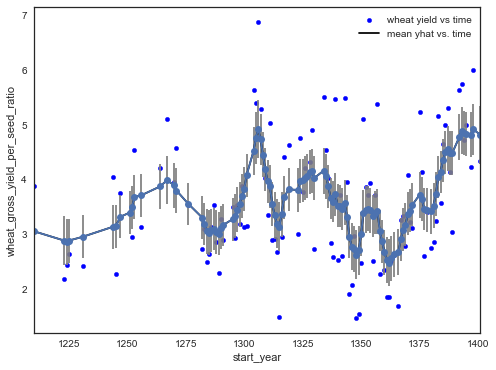

In [216]:
sns.set_style("white")
ax = adderbury_complete_wheat.plot(kind="scatter", x="start_year",y="wheat_gross_yield_per_seed_ratio",
                                   color="b", label="wheat yield vs time",figsize=(8,6))
adderbury_complete_wheat.plot(x="start_year",y="mean_yhat", color="black", label="mean yhat vs. time", ax=ax)
ax.errorbar(adderbury_complete_wheat.start_year, adderbury_complete_wheat.mean_yhat, yerr=y_uncertainity, fmt='-o',
           ecolor="grey")